In [130]:
import os
from pprint import pprint
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier, CatBoostRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from datetime import datetime
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
ROOT_DIR = "data"
RANDOM_STATE = 110

EXAMPLE_MODE = False

if EXAMPLE_MODE:
    df = pd.read_csv('data/bank.csv')
    df_train, df_test = generate_example(df)
    print("EXAMPLE MODE")
    
else:
    #df_fund = pd.read_csv('data/fund.csv')
    #df_bank = pd.read_csv('data/bank2.csv') # .drop("Set ID", axis=1)
    df_loan = pd.read_csv('data/Loan.csv')
    print("REAL MODE")

REAL MODE


사용자 정보 입력 시 다 입력하라고 하기?

In [134]:
# 모든 컬럼을 출력할 수 있도록 설정
pd.set_option('display.max_columns', None)

# 컬럼 출력
print(df_loan.columns)

# 데이터프레임의 앞부분 출력
print(df_loan.head(20))

Index(['ApplicationDate', 'Age', 'AnnualIncome', 'CreditScore',
       'EmploymentStatus', 'EducationLevel', 'Experience', 'LoanAmount',
       'LoanDuration', 'MaritalStatus', 'NumberOfDependents',
       'HomeOwnershipStatus', 'MonthlyDebtPayments',
       'CreditCardUtilizationRate', 'NumberOfOpenCreditLines',
       'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory',
       'LoanPurpose', 'PreviousLoanDefaults', 'PaymentHistory',
       'LengthOfCreditHistory', 'SavingsAccountBalance',
       'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities',
       'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'NetWorth',
       'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment',
       'TotalDebtToIncomeRatio', 'LoanApproved', 'RiskScore'],
      dtype='object')
   ApplicationDate  Age  AnnualIncome  CreditScore EmploymentStatus  \
0       2018-01-01   45         39948          617         Employed   
1       2018-01-02   38         39709          62

Remove NAN

In [137]:
drop_cols = []
for column in df_loan.columns:
    if (df_loan[column].notnull().sum() == 0):
        drop_cols.append(column)

df_loan = df_loan.drop(drop_cols, axis=1)
#df_test = df_test.drop(drop_cols, axis=1)
print(drop_cols)

[]


Remove constant data

In [140]:
drop_cols = []
for column in df_loan.columns:
    if df_loan[column].nunique() == 1:
        drop_cols.append(column)

df_train = df_loan.drop(drop_cols, axis=1)
#df_test = df_test.drop(drop_cols, axis=1)
print(drop_cols)

[]


In [141]:
# date 컬럼을 datetime 형식으로 변환
df_loan['ApplicationDate'] = pd.to_datetime(df_loan['ApplicationDate'])

# 날짜로부터 새로운 컬럼 생성
df_loan['Year'] = df_loan['ApplicationDate'].dt.year
df_loan['Month'] = df_loan['ApplicationDate'].dt.month
df_loan['Day'] = df_loan['ApplicationDate'].dt.day

# age 컬럼의 위치 찾기
age_index = df_loan.columns.get_loc('Age')

# 새로운 컬럼이 이미 존재할 경우 제거 후 삽입
for col in ['Year', 'Month', 'Day']:
    if col in df_loan.columns:
        df_loan.drop(columns=[col], inplace=True)
    df_loan.insert(age_index, col, df_loan['ApplicationDate'].dt.__getattribute__(col.lower()))

# 결과 출력
df_loan.drop(columns=['ApplicationDate'], inplace=True)
print(df_loan)


       Day  Month  Year  Age  AnnualIncome  CreditScore EmploymentStatus  \
0        1      1  2018   45         39948          617         Employed   
1        2      1  2018   38         39709          628         Employed   
2        3      1  2018   47         40724          570         Employed   
3        4      1  2018   58         69084          545         Employed   
4        5      1  2018   37        103264          594         Employed   
...    ...    ...   ...  ...           ...          ...              ...   
19995   29      9  2072   44         30180          587         Employed   
19996   30      9  2072   56         49246          567         Employed   
19997    1     10  2072   44         48958          645         Employed   
19998    2     10  2072   60         41025          560         Employed   
19999    3     10  2072   20         53227          574         Employed   

      EducationLevel  Experience  LoanAmount  LoanDuration MaritalStatus  \
0          

In [142]:
df_loan.head(3)

,Day,Month,Year,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,DebtToIncomeRatio,BankruptcyHistory,LoanPurpose,PreviousLoanDefaults,PaymentHistory,LengthOfCreditHistory,SavingsAccountBalance,CheckingAccountBalance,TotalAssets,TotalLiabilities,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,1,1,2018,45,39948,617,Employed,Master,22,13152,48,Married,2,Own,183,0.354418,1,2,0.358336,0,Home,0,29,9,7632,1202,146111,19183,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077,0,49.0
1,2,1,2018,38,39709,628,Employed,Associate,15,26045,48,Single,1,Mortgage,496,0.087827,5,3,0.330274,0,Debt Consolidation,0,21,9,4627,3460,53204,9595,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852,0,52.0
2,3,1,2018,47,40724,570,Employed,Bachelor,26,17627,36,Married,2,Rent,902,0.137414,2,0,0.244729,0,Education,0,20,22,886,895,25176,128874,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157,0,52.0


In [143]:
# EmploymentStatus 컬럼을 숫자로 변환
df_loan['LoanPurpose'] = df_loan['LoanPurpose'].replace({
    'Education': 0,
    'Home': 1,
    'Debt Consolidation': 2,
    'Auto' : 3,
    'Other' : 4
}).astype(int)  # 값을 정수형(int)으로 변환

# 결과 출력
print(df_loan)

       Day  Month  Year  Age  AnnualIncome  CreditScore EmploymentStatus  \
0        1      1  2018   45         39948          617         Employed   
1        2      1  2018   38         39709          628         Employed   
2        3      1  2018   47         40724          570         Employed   
3        4      1  2018   58         69084          545         Employed   
4        5      1  2018   37        103264          594         Employed   
...    ...    ...   ...  ...           ...          ...              ...   
19995   29      9  2072   44         30180          587         Employed   
19996   30      9  2072   56         49246          567         Employed   
19997    1     10  2072   44         48958          645         Employed   
19998    2     10  2072   60         41025          560         Employed   
19999    3     10  2072   20         53227          574         Employed   

      EducationLevel  Experience  LoanAmount  LoanDuration MaritalStatus  \
0          

/var/folders/d4/2kvwj_k92w5b5hs2mxxz0zb80000gn/T/ipykernel_3006/990783083.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_loan['LoanPurpose'] = df_loan['LoanPurpose'].replace({


In [144]:
# EmploymentStatus 컬럼을 숫자로 변환
df_loan['HomeOwnershipStatus'] = df_loan['HomeOwnershipStatus'].replace({
    'Rent': 0,
    'Mortgage': 1,
    'Own': 2,
    'Other' : 3
}).astype(int)  # 값을 정수형(int)으로 변환

# 결과 출력
print(df_loan)

       Day  Month  Year  Age  AnnualIncome  CreditScore EmploymentStatus  \
0        1      1  2018   45         39948          617         Employed   
1        2      1  2018   38         39709          628         Employed   
2        3      1  2018   47         40724          570         Employed   
3        4      1  2018   58         69084          545         Employed   
4        5      1  2018   37        103264          594         Employed   
...    ...    ...   ...  ...           ...          ...              ...   
19995   29      9  2072   44         30180          587         Employed   
19996   30      9  2072   56         49246          567         Employed   
19997    1     10  2072   44         48958          645         Employed   
19998    2     10  2072   60         41025          560         Employed   
19999    3     10  2072   20         53227          574         Employed   

      EducationLevel  Experience  LoanAmount  LoanDuration MaritalStatus  \
0          

/var/folders/d4/2kvwj_k92w5b5hs2mxxz0zb80000gn/T/ipykernel_3006/3416562489.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_loan['HomeOwnershipStatus'] = df_loan['HomeOwnershipStatus'].replace({


In [145]:
# EmploymentStatus 컬럼을 숫자로 변환
df_loan['EmploymentStatus'] = df_loan['EmploymentStatus'].replace({
    'Employed': 1,
    'Unemployed': 0,
    'Self-Employed': 2
}).astype(int)  # 값을 정수형(int)으로 변환

# 결과 출력
print(df_loan)


       Day  Month  Year  Age  AnnualIncome  CreditScore  EmploymentStatus  \
0        1      1  2018   45         39948          617                 1   
1        2      1  2018   38         39709          628                 1   
2        3      1  2018   47         40724          570                 1   
3        4      1  2018   58         69084          545                 1   
4        5      1  2018   37        103264          594                 1   
...    ...    ...   ...  ...           ...          ...               ...   
19995   29      9  2072   44         30180          587                 1   
19996   30      9  2072   56         49246          567                 1   
19997    1     10  2072   44         48958          645                 1   
19998    2     10  2072   60         41025          560                 1   
19999    3     10  2072   20         53227          574                 1   

      EducationLevel  Experience  LoanAmount  LoanDuration MaritalStatus  \

/var/folders/d4/2kvwj_k92w5b5hs2mxxz0zb80000gn/T/ipykernel_3006/1250503428.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_loan['EmploymentStatus'] = df_loan['EmploymentStatus'].replace({


In [146]:
# EducationLevel 컬럼을 숫자로 변환
df_loan['EducationLevel'] = df_loan['EducationLevel'].replace({
    'High School': 0,
    'Associate': 1,
    'Bachelor': 2,
    'Master': 3,
    'Doctorate' : 4
}).astype(int)  # 값을 정수형(int)으로 변환

# 결과 출력
print(df_loan)


       Day  Month  Year  Age  AnnualIncome  CreditScore  EmploymentStatus  \
0        1      1  2018   45         39948          617                 1   
1        2      1  2018   38         39709          628                 1   
2        3      1  2018   47         40724          570                 1   
3        4      1  2018   58         69084          545                 1   
4        5      1  2018   37        103264          594                 1   
...    ...    ...   ...  ...           ...          ...               ...   
19995   29      9  2072   44         30180          587                 1   
19996   30      9  2072   56         49246          567                 1   
19997    1     10  2072   44         48958          645                 1   
19998    2     10  2072   60         41025          560                 1   
19999    3     10  2072   20         53227          574                 1   

       EducationLevel  Experience  LoanAmount  LoanDuration MaritalStatus  

/var/folders/d4/2kvwj_k92w5b5hs2mxxz0zb80000gn/T/ipykernel_3006/498174319.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_loan['EducationLevel'] = df_loan['EducationLevel'].replace({


In [147]:
# Marriage 컬럼을 숫자로 변환
df_loan['MaritalStatus'] = df_loan['MaritalStatus'].replace({
    'Single': 0,
    'Married': 1,
    'Divorced' : 2,
    'Widowed' : 3
}).astype(int)  # 값을 정수형(int)으로 변환

# 결과 출력
print(df_loan)

       Day  Month  Year  Age  AnnualIncome  CreditScore  EmploymentStatus  \
0        1      1  2018   45         39948          617                 1   
1        2      1  2018   38         39709          628                 1   
2        3      1  2018   47         40724          570                 1   
3        4      1  2018   58         69084          545                 1   
4        5      1  2018   37        103264          594                 1   
...    ...    ...   ...  ...           ...          ...               ...   
19995   29      9  2072   44         30180          587                 1   
19996   30      9  2072   56         49246          567                 1   
19997    1     10  2072   44         48958          645                 1   
19998    2     10  2072   60         41025          560                 1   
19999    3     10  2072   20         53227          574                 1   

       EducationLevel  Experience  LoanAmount  LoanDuration  MaritalStatus 

/var/folders/d4/2kvwj_k92w5b5hs2mxxz0zb80000gn/T/ipykernel_3006/2930668858.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_loan['MaritalStatus'] = df_loan['MaritalStatus'].replace({


In [148]:
#feature importance
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 예시 데이터 불러오기
#df = pd.read_csv('.csv')
X = df_loan.drop('LoanApproved', axis=1)  # feature 변수들
y = df_loan['LoanApproved']               # 타겟 변수

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# feature importance 추출
importances = model.feature_importances_
features = X.columns

# 결과를 DataFrame으로 정리
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# feature importance 출력
print(feature_importance_df)


                       Feature  Importance
36                   RiskScore    0.468746
35      TotalDebtToIncomeRatio    0.112732
4                 AnnualIncome    0.108087
28               MonthlyIncome    0.089472
33                InterestRate    0.039163
9                   LoanAmount    0.023258
26                 TotalAssets    0.016246
34          MonthlyLoanPayment    0.015397
31                    NetWorth    0.014852
32            BaseInterestRate    0.012258
18           DebtToIncomeRatio    0.011254
5                  CreditScore    0.008293
10                LoanDuration    0.007878
23       LengthOfCreditHistory    0.007305
7               EducationLevel    0.005757
14         MonthlyDebtPayments    0.005067
3                          Age    0.004567
8                   Experience    0.004220
15   CreditCardUtilizationRate    0.004170
24       SavingsAccountBalance    0.003758
25      CheckingAccountBalance    0.003743
27            TotalLiabilities    0.003739
29  Utility

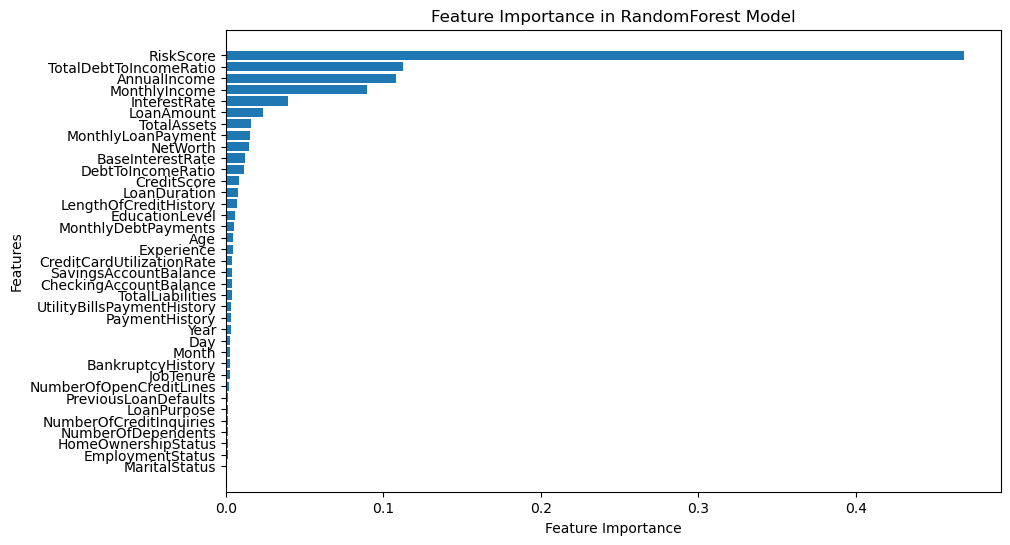

In [ ]:
import matplotlib.pyplot as plt
# feature importance 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in RandomForest Model")
plt.show()

FICO 점수 계산 방식

FICO 점수는 300에서 850 사이의 점수로 나타내며, 일반적으로 다음 요소들이 포함되어 계산

- 결제 이력 (Payment History) - 35%
대출 상환 여부, 연체 여부 등
- 부채 수준 (Amount Owed) - 30%
현재 빚의 양, 신용카드 사용률(credit utilization rate)
- 신용 이력 길이 (Length of Credit History) - 15%
신용 계좌를 개설한 기간, 신용카드 사용 기간
- 새로운 신용 (New Credit) - 10%
최근 개설된 신용 계좌 수, 최근 신용 조회 횟수
- 신용 종류 (Credit Mix) - 10%
다양한 종류의 신용(예: 신용카드, 대출 등)을 보유한 정도
